## Pump it up! Modeling work

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('water_training.csv', header=0)
labels = pd.read_csv('water_training_labels.csv', header=0)

df=df.merge(labels, how='left', left_on='id', right_on='id',copy=False)

In [3]:
# use pandas to read in data

#df_X = pd.read_csv('../data/train_X.csv')
#df_y = pd.read_csv('../data/train_y.csv')
#df = pd.merge(df_y, df_X, on='id')

# -- convert functional to 2, non-functional to 0, functional-needs-repaird to 1

df.loc[:, 'status'] = df.status_group
df.loc[df.status.str.startswith('functional needs'), 'status'] = 1
df.loc[df.status_group.str.startswith('non'), 'status'] = 0
df.loc[~df.status.str.startswith('functional').isnull(), 'status'] = 2
df.status = df.status.astype(int)

# -- show df.corr()
df.corr()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status
id,1.000000,-0.005321,-0.004692,-0.001348,0.001718,-0.002629,-0.003028,-0.003044,-0.002813,-0.002082,-0.004049
amount_tsh,-0.005321,1.000000,0.076650,0.022134,-0.052670,0.002944,-0.026813,-0.023599,0.016288,0.067915,0.053702
gps_height,-0.004692,0.076650,1.000000,0.149155,-0.035751,0.007237,-0.183521,-0.171233,0.135003,0.658727,0.114029
longitude,-0.001348,0.022134,0.149155,1.000000,-0.425802,0.023873,0.034197,0.151398,0.086590,0.396732,-0.004366
latitude,0.001718,-0.052670,-0.035751,-0.425802,1.000000,0.006837,-0.221018,-0.201020,-0.022152,-0.245278,0.014547
num_private,-0.002629,0.002944,0.007237,0.023873,0.006837,1.000000,-0.020377,-0.004478,0.003818,0.026056,0.005021
region_code,-0.003028,-0.026813,-0.183521,0.034197,-0.221018,-0.020377,1.000000,0.678602,0.094088,0.031724,-0.108640
district_code,-0.003044,-0.023599,-0.171233,0.151398,-0.201020,-0.004478,0.678602,1.000000,0.061831,0.048315,-0.065687
population,-0.002813,0.016288,0.135003,0.086590,-0.022152,0.003818,0.094088,0.061831,1.000000,0.260910,0.017759
construction_year,-0.002082,0.067915,0.658727,0.396732,-0.245278,0.026056,0.031724,0.048315,0.260910,1.000000,0.043342


the highest abs|correlation| is gps_height for the continuous variable
it does not say much

Initial exploration on the data

In [4]:
# import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
import patsy

I am having my first trial by just removing features that have too many
dummies

In [5]:
from itertools import combinations
import itertools

In [6]:
def ready_for_model(df):
    cols = list(df.columns.values)

    # keep columns
    cols_keep = []
    cols_giveup = []
    for c in df:
        if df[c].dtype in [int, float]:
            cols_keep.append(c)
        elif df[c].dtype == object:
            if df[c].nunique() < 25:
                cols_keep.append(c)
            else:
                cols_giveup.append(c)

    # remove the labels
    for to_remove in ['id', 'status', 'status_group']:
        cols_keep.remove(to_remove)

    # convert df to X, y by patsy
    r_formula = 'status ~' + ' + '.join(cols_keep)
    df_y, df_X = patsy.dmatrices(r_formula, df, return_type='dataframe')

    cols_X = df_X.columns
    X = df_X.values
    y = df_y.values
    return (df_X, X, y, cols_X, r_formula, cols_keep, cols_giveup)

df_X, X, y, cols_X, r_formula, cols_keep, cols_giveup = ready_for_model(df)

In [7]:
cols_X = cols_X.drop('Intercept')

In [8]:
cols_X_2 = list(itertools.combinations(cols_X,2))

In [9]:
import re

In [10]:
combo_keep = []
for c1, c2 in cols_X_2:
    if re.search("\[T\.", c1) and re.search("\[T\.", c2):
        continue
    c1_left=c1.split('[')[0]
    c2_left = c2.split('[')[0] 
    if not c2.startswith(c1_left):
        combo_keep.append([c1,c2])



In [11]:
len(combo_keep)

1375

In [12]:
for c1, c2 in combo_keep:
    df_X[c1+c2] = df_X[c1]* df_X[c2]
df_X.head()  
#interactions

,Intercept,basin[T.Lake Nyasa],basin[T.Lake Rukwa],basin[T.Lake Tanganyika],basin[T.Lake Victoria],basin[T.Pangani],basin[T.Rufiji],basin[T.Ruvuma / Southern Coast],basin[T.Wami / Ruvu],region[T.Dar es Salaam],...,num_privateregion_code,num_privatedistrict_code,num_privatepopulation,num_privateconstruction_year,region_codedistrict_code,region_codepopulation,region_codeconstruction_year,district_codepopulation,district_codeconstruction_year,populationconstruction_year
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,55.0,1199.0,21989.0,545.0,9995.0,217891.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,84.0,5250.0,42189.0,1000.0,8036.0,502250.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5670.0,5220.0,178740.0,3654.0,125118.0,115188.0
5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,32.0,4.0,8036.0,8.0,16072.0,2009.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,51.0,0.0,0.0,0.0,0.0,0.0


In [166]:
#cols_X_3 = list(itertools.combinations(cols_X,3))

In [168]:
#combo_keep = []
#for c1, c2, c3 in cols_X_3:
#    if re.search("\[T\.", c1) and re.search("\[T\.", c2) and re.search("\[T\.", c3):
#        continue
#    c1_left=c1.split('[')[0]
#    c2_left = c2.split('[')[0] 
#    c3_left = c3.split('[')[0]
#    if not c2.startswith(c1_left) or c3.startswith(c2_left):
#        combo_keep.append([c1,c2,c3])




In [173]:
#for c1, c2, c3 in combo_keep:
#    df_X[c1+c2+c3] = df_X[c1]* df_X[c2] * df_X[c3]
#df_X.head()    

KeyboardInterrupt: 

In [13]:
def split_n_fit(model, X, y):
    """ given model, X, y, print score of the fit on test """
    X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), random_state=42)
    model.fit(X_train, y_train)
    print
    print '{}'.format(model).split('(')[0]
    print model.score(X_test, y_test)

X = df_X.values
y = y
#model = RandomForestClassifier(n_estimators=200)
#split_n_fit(model, X, y)

for model in [LogisticRegression(), DecisionTreeClassifier(),
              KNeighborsClassifier(), GaussianNB(), RandomForestClassifier()]:
    split_n_fit(model, X, y)
#with two level interactions
#Most of these scores are **Worse** than before! (see below)


LogisticRegression
0.609501645133

DecisionTreeClassifier
0.757643848808

KNeighborsClassifier
0.678516972956

GaussianNB
0.277425567771

RandomForestClassifier
0.795040526443


In [14]:
# it looks RandomForest does us better, let's try a new parameter

model = RandomForestClassifier(n_estimators=200)
split_n_fit(model, X, y)


RandomForestClassifier
0.810930101918


In [15]:
# it looks RandomForest does us better, let's try a new parameter

model = RandomForestClassifier(n_estimators=300)
split_n_fit(model, X, y)


RandomForestClassifier
0.808923842388


In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# in tree and ensemble type of models, we can use feature_importances_
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = importances.argsort()[::-1]
print "Features ranked by importance:"
for i, (feature, importance) in enumerate(zip(df_X.columns[indices], importances[indices])):
    print i, feature, importance

Features ranked by importance:
0 quantity_group[T.enough]latitude 0.00899153847612
1 quantity_group[T.enough]longitude 0.0088398294565
2 latitude 0.0084423207144
3 quantity[T.enough]longitude 0.00843757255075
4 longitudelatitude 0.00831475857504
5 longitude 0.00828535628331
6 latitudedistrict_code 0.00827034849298
7 longitudedistrict_code 0.00816261145888
8 latituderegion_code 0.008105452696
9 longituderegion_code 0.00796154651091
10 quantity[T.enough]latitude 0.00790527875957
11 public_meeting[T.True]longitude 0.00737402859105
12 public_meeting[T.True]latitude 0.00736594721266
13 quality_group[T.good]longitude 0.00726400693475
14 management_group[T.user-group]latitude 0.0071286757253
15 management_group[T.user-group]longitude 0.00712184230003
16 quality_group[T.good]latitude 0.00700991398591
17 water_quality[T.soft]longitude 0.00694070329753
18 water_quality[T.soft]latitude 0.00669380446801
19 management[T.vwc]latitude 0.00629460824484
20 management[T.vwc]longitude 0.00625417790876
21

# Janine's code is below.  But you can compare the model scores with interaction terms (above) with the scores without (below).

In [11]:
def split_n_fit(model, X, y):
    """ given model, X, y, print score of the fit on test """
    X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), random_state=42)
    model.fit(X_train, y_train)
    print
    print '{}'.format(model).split('(')[0]
    print model.score(X_test, y_test)


for model in [LogisticRegression(), DecisionTreeClassifier(),
              KNeighborsClassifier(), GaussianNB(), RandomForestClassifier()]:
    split_n_fit(model, X, y)


LogisticRegression
0.715191397159

DecisionTreeClassifier
0.757724099189

KNeighborsClassifier
0.691116282802

GaussianNB
0.501645132814

RandomForestClassifier
0.787015488324


In [12]:
# it looks RandomForest does us better, let's try a new parameter

model = RandomForestClassifier(n_estimators=200)
split_n_fit(model, X, y)


RandomForestClassifier
0.804831072948


In [9]:
# it looks RandomForest does us better, let's try a new parameter

model = RandomForestClassifier(n_estimators=300)
split_n_fit(model, X, y)


RandomForestClassifier
0.805633576759


In [13]:
from sklearn.cross_validation import KFold

model = RandomForestClassifier(n_estimators=200)
y = y.ravel()
for train_index, test_index in KFold(len(y), n_folds=5):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    model.fit(X_train, y_train)
    print model.score(X_test, y_test)

0.803089577691
0.798856340289
0.804073033708
0.804775280899
0.797953451043


In [14]:
from sklearn.metrics import confusion_matrix
# get y_pred and y_actual
y_pred = model.predict(X_test)
y_actual = y_test

# convert y's to binary

# y_pred_bin = ~y_pred.astype(bool)  
# y_actual_bin = ~y_actual.astype(bool)  #

# we want True means not-functional or need-repair (where the govern. needs to send people) , False: functional
# In our data, 2: functional 1: need repair 0: non-functional
y_pred_bin = (y_pred < 2)
y_actual_bin = (y_actual < 2)

conf = confusion_matrix(y_actual_bin, y_pred_bin)
conf

array([[4747,  762],
       [1030, 3429]])

In [33]:
TP = conf[0, 0]
FN = conf[0, 1]
FP = conf[1, 0]
TN = conf[1, 1]
recall = TP * 1./ (TP + FN)
print "recall", recall
precision = TP * 1./ (TP + FP)
print "precision", precision

recall 0.864766745326
precision 0.822797927461


so far, we only used the automatic feature selection.
To get some idea of what feature really matters, we can check
the importance of features

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# in tree and ensemble type of models, we can use feature_importances_
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = importances.argsort()[::-1]
print "Features ranked by importance:"
for i, (feature, importance) in enumerate(zip(cols_X[indices], importances[indices])):
    print i, feature, importance

Features ranked by importance:
0 longitude 0.144659383521
1 latitude 0.141665429174
2 gps_height 0.0713386683027
3 construction_year 0.0529269439682
4 population 0.0491276663002
5 district_code 0.0265975323765
6 quantity_group[T.enough] 0.024903345537
7 quantity[T.enough] 0.0233166958454
8 amount_tsh 0.0214150480932
9 region_code 0.0178157176716
10 quantity_group[T.insufficient] 0.0153723642808
11 quantity[T.insufficient] 0.014642100429
12 waterpoint_type[T.other] 0.0142902592432
13 waterpoint_type_group[T.other] 0.0141665361602
14 payment_type[T.never pay] 0.0139045141165
15 extraction_type_class[T.other] 0.0132211254466
16 extraction_type[T.other] 0.0117851218976
17 extraction_type_group[T.other] 0.0109182783557
18 permit[T.True] 0.0101501551056
19 quantity[T.seasonal] 0.00938915901111
20 waterpoint_type[T.communal standpipe] 0.00937798604696
21 waterpoint_type[T.communal standpipe multiple] 0.00904408646517
22 quantity_group[T.seasonal] 0.00833994357373
23 public_meeting[T.True] 0.0

In [15]:
importances.sum()

1.0

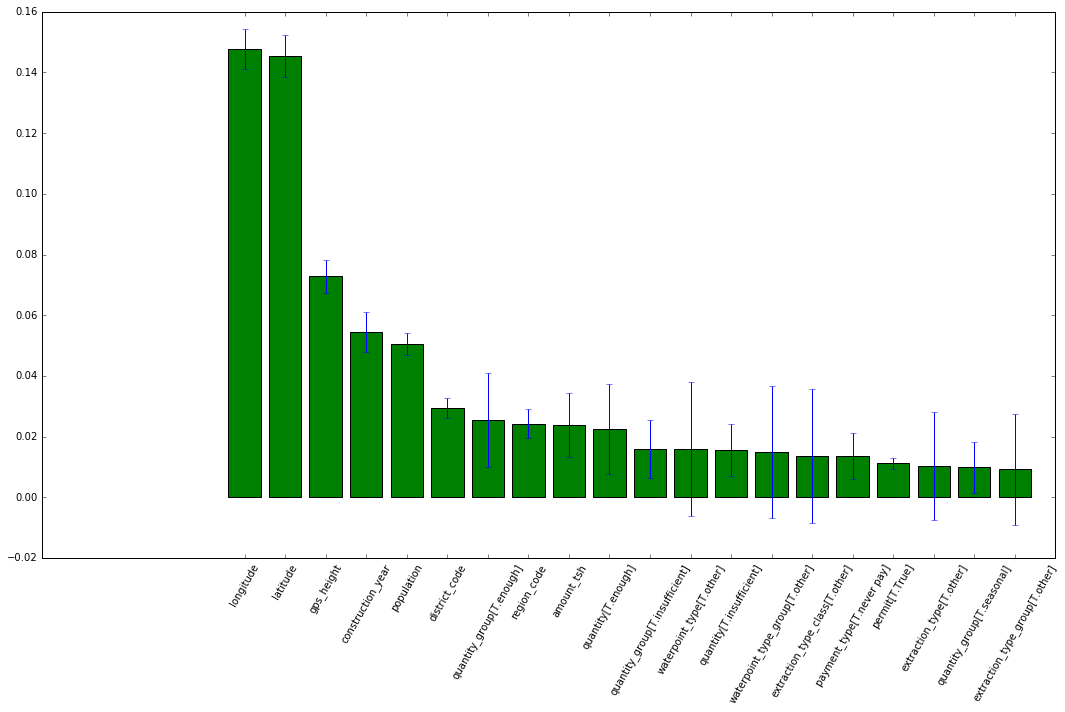

In [17]:
# just plot the first 20
n_first = 20
plt.figure(figsize=[15, 10])
plt.bar(range(n_first), importances[indices[0:20]], color='g',
        yerr=std[indices[0:20]], align='center')
plt.xticks(range(n_first), cols_X[indices[0:20]], rotation=60)
plt.tight_layout()
plt.show()

### Now, let's do some imputation
please note that this is not the correct way to do imputation (the correct way should be that we only impute on the training dataset and apply imputation function to the test later), but for now it gives a good indicator that if the missing values are affecting our modeling work.

for population, we'll first try to fill in missing value with the mean of groups

In [47]:
# it is copied from Ash's code
# firstly, replace 
dat = df.copy()
dat.population.replace(to_replace={0: np.nan}, inplace=True)

In [48]:
#let's look at population by imputing with mean population in neighboring areas, in this order:
#sub-village > ward > lga > region_code

dat.population.fillna(dat.groupby(['subvillage'])['population'].transform('mean'), inplace=True)
dat.population.fillna(dat.groupby(['ward'])['population'].transform('mean'), inplace=True)
dat.population.fillna(dat.groupby(['lga'])['population'].transform('mean'), inplace=True)
dat.population.fillna(dat.groupby(['region_code'])['population'].transform('mean'), inplace=True)

In [49]:
X, y, cols_X, r_formula, cols_keep, cols_giveup = ready_for_model(dat)

In [50]:
for model in [LogisticRegression(), DecisionTreeClassifier(),
              KNeighborsClassifier(), GaussianNB(), RandomForestClassifier()]:
    split_n_fit(model, X, y)


LogisticRegression
0.728833961961

DecisionTreeClassifier
0.756520343472

KNeighborsClassifier
0.672819195891

GaussianNB
0.501243880908

RandomForestClassifier
0.788058743279


In [51]:
# it looks RandomForest does us better, let's try a new parameter

model = RandomForestClassifier(n_estimators=200)
split_n_fit(model, X, y)


RandomForestClassifier
0.806275579809


In [52]:
# it looks RandomForest does us better, let's try a new parameter

model = RandomForestClassifier(n_estimators=300)
split_n_fit(model, X, y)


RandomForestClassifier
0.806115079047


In [53]:
## LOCATION
# gps_height

(dat.gps_height == 0).sum()/float(len(dat.gps_height))

0.34407407407407409

In [58]:
dat = df.copy()
dat.gps_height.replace(to_replace={0: np.nan}, inplace=True)
#let's look at gps_height by imputing with mean gps_height in neighboring areas, in this order:
#sub-village > ward > lga > region_code

dat.gps_height.fillna(dat.groupby(['subvillage'])['gps_height'].transform('mean'), inplace=True)
dat.gps_height.fillna(dat.groupby(['ward'])['gps_height'].transform('mean'), inplace=True)
dat.gps_height.fillna(dat.groupby(['lga'])['gps_height'].transform('mean'), inplace=True)
dat.gps_height.fillna(dat.groupby(['region_code'])['gps_height'].transform('mean'), inplace=True)

In [59]:
X, y, cols_X, r_formula, cols_keep, cols_giveup = ready_for_model(dat)

In [60]:
for model in [LogisticRegression(), DecisionTreeClassifier(),
              KNeighborsClassifier(), GaussianNB(), RandomForestClassifier()]:
    split_n_fit(model, X, y)


LogisticRegression
0.725944948239

DecisionTreeClassifier
0.752989326699

KNeighborsClassifier
0.668886927213

GaussianNB
0.501083380146

RandomForestClassifier
0.787817992135


In [61]:
# it looks RandomForest does us better, let's try a new parameter

model = RandomForestClassifier(n_estimators=200)
split_n_fit(model, X, y)


RandomForestClassifier
0.806034828665
